In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from data_interpreter_with_excision import dataInterpreter, metaDataEndomondo

global endo_reader
endo_reader = None

def loadData(fileName):
    print("Loading data file")
    with open(fileName, "rb") as f:
        data = pickle.load(f)
    #except:
    #    raise(IOError("Data file: " + fileName + " not in valid pickle format"))
    print("Data file loaded")
    return data
        
            
class dataEpoch(object):
    def __init__(self, targetSeq, logitSeq, inputSeq, outputsSeq, outputSeq, epochNum):
        self.inputSeq = inputSeq
        self.targetSeq = targetSeq
        self.logitSeq = logitSeq
        #self.outputsSeq = outputsSeq
        #self.outputSeq = outputSeq
        global endoFeatures
        global inputOrderNames
        global model
        global lossType
        global targetAtt
        global trimmed_workout_length
        self.epochNum = epochNum
        self.endoFeatures = endoFeatures
        self.inputOrderNames = inputOrderNames
        self.targetAtt = targetAtt
        self.modelType = model
        self.lossType = lossType
        self.trainValTestSplit = trainValTestSplit
        self.modelRunIdentifier = modelRunIdentifier
        self.zMultiple = zMultiple
        self.trimmed_workout_length = trimmed_workout_length
        
def rescaleZscoredData(data, sequence, att):
    #Removes the z score scaling. Does this by loading an endoreader and getting the varmeans and stds from that, 
    #then performing arithmetic operations on the data sequence
    global endo_reader
    if endo_reader is None:
        endo_reader = dataInterpreter(fn="../multimodalDBM/endomondoHR_proper.json", scaleVals=True)
        endo_reader.buildDataSchema(data.endoFeatures, data.targetAtt, data.trainValTestSplit, data.zMultiple)
        
    variableMeans = endo_reader.variableMeans
    variableStds = endo_reader.variableStds
    
    unMult = [x/float(data.zMultiple) for x in sequence]
    diff = [x*float(variableStds[att]) for x in unMult]
    raw = [x+float(variableMeans[att]) for x in diff]
    return raw
        
def transformData(data, sequenceLength=500, unZscore = True, useInputs=False):
    #Rewrite this to split at the new workout marker!!!
    isSequence = {'altitude':True, 'gender':False, 'heart_rate':True, 'id':False, 'latitude':True, 'longitude':True,
                             'speed':True, 'sport':False, 'timestamp':True, 'url':False, 'userId':False, 'time_elapsed': True, 
                             'distance':True, 'new_workout':True, 'derived_speed':True}
    
    if useInputs:
        inputAtts = [x for x in data.endoFeatures if x != data.targetAtt]
    if unZscore:
        predictionsList = rescaleZscoredData(data, data.logitSeq, data.targetAtt)
        targetsList = rescaleZscoredData(data, data.targetSeq, data.targetAtt)
        if useInputs:
            attLists = []
            #inputsList = data.inputSeq
            for i, att in enumerate(inputAtts):
                curAttList = [data.inputSeq[j][i] for j in range(len(data.inputSeq))]
                if isSequence[att]:
                    attLists.append(rescaleZscoredData(data, curAttList, att))
                else:
                    attLists.append(curAttList)
            #Now I need to zip them
            #inputsList = [[x[i] for x in attLists] for i in range(len(data.inputSeq))]#Intense code ;)
    else:
        predictionsList = data.logitSeq
        targetsList = data.targetSeq
        if useInputs:
            #inputsList = data.inputSeq
            attLists = []
            for i, att in enumerate(inputAtts):
                #if isSequence[att]:
                curAttList = [data.inputSeq[j][i] for j in range(len(data.inputSeq))]
                attLists.append(curAttList)
                #else:
                #    attLists.append(data.inputSeq[j][i])
                    
            
            #print("first entry of inputslist: " + str(inputsList[0]))
            #print("len prelist: " + str(len(predictionsList)))
            #print("len tarlist: " + str(len(targetsList)))
            #print("len inplist: " + str(len(inputsList)))
        
    numRows = int(len(predictionsList)/sequenceLength)
    predictionsByWorkout = np.zeros((numRows, sequenceLength))
    targetsByWorkout = np.zeros((numRows, sequenceLength))
    if useInputs:
        #inputsByWorkout = np.zeros((numRows, sequenceLength),dtype=list)
        inputAttsByWorkout = {}
        for i, att in enumerate(inputAtts):
            #inputAttsByWorkout[att] = np.zeros((numRows, sequenceLength))
            inputAttsByWorkout[att] = []
    #Now transform the lists into n x 500 arrays
    for i in range(numRows):
        predictionsByWorkout[i,:] = predictionsList[i*sequenceLength : (i+1)*sequenceLength]
        targetsByWorkout[i,:] = targetsList[i*sequenceLength : (i+1)*sequenceLength]
        if useInputs:
            for k, att in enumerate(inputAtts):
                currentAttList = attLists[k]
                #print currentAttList
                #inputAttsByWorkout[att][i,:] = currentAttList[i*sequenceLength : (i+1)*sequenceLength]
                inputAttsByWorkout[att].append(currentAttList[i*sequenceLength : (i+1)*sequenceLength])
            #for j in range(sequenceLength):
                #temp = inputsList[i*sequenceLength+j]
                #inputsByWorkout[i,j] = temp
                #print(i)
                #print(j)
                    
            
    if useInputs:
        #return (predictionsByWorkout, targetsByWorkout, inputsByWorkout, inputAttsByWorkout)
        return (predictionsByWorkout, targetsByWorkout, inputAttsByWorkout)
    else:
        return (predictionsByWorkout, targetsByWorkout)

def buildDataFrame(data, unZscore = True, useInputs=True):
    predictionsByWorkout, targetsByWorkout, inputAttsByWorkout = transformData(data, sequenceLength=500, 
                                                                                                unZscore=unZscore, useInputs=useInputs)
    
    inputOrderSeq = [x for x in data.endoFeatures if x!= data.targetAtt]

    #Now build a PANDAS dataframe
    columns = ['Targets','Predictions']
    columns.extend(inputOrderSeq)
    df = pd.DataFrame(columns=columns, dtype='object')
    df['Targets'] = targetsByWorkout
    df['Predictions'] = predictionsByWorkout
    
    for i, att in enumerate(inputOrderSeq):
        if isSequence[att]:
            #Take the whole sequence
            df[att] = inputAttsByWorkout[att]
        else:
            #Take just the first value
            pass
        
    return df
    

def sampleAverageBenchmark(data, unZscore = True, errorType="MAE"):
    """Computes the error of a model that takes the sample average of the targets and uses it to predict each data point
    This is only equivalent to using the full data average as a predictor if the sample includes all data points from the
    data set and only data points from the data set with no repeats.
    """
    if unZscore:
        targetsList = rescaleZscoredData(data, data.targetSeq, data.targetAtt)
    else:
        targetsList = data.targetSeq
    meanTarget = np.mean(targetsList)
    #print(meanTarget)
    if errorType == "MAE":
        errorScore = np.mean([abs((target)-meanTarget) for target in targetsList])
    if errorType == "RMSE":
        errorScore = np.sqrt(np.mean([np.power(((target)-meanTarget),2) for target in targetsList]))
    #else:
    #    raise(exception("Error type not recognized"))
    
    return errorScore

def sampleModelPerformance(data, unZscore = True, errorType="MAE"):
    if unZscore:
        predictionsList = rescaleZscoredData(data, data.logitSeq, data.targetAtt)
        targetsList = rescaleZscoredData(data, data.targetSeq, data.targetAtt)
    else:
        predictionsList = data.logitSeq
        targetsList = data.targetSeq
    
    if errorType == "MAE":
        errorScore = np.mean([abs((targetsList[i])-(predictionsList[i])) for i in range(len(predictionsList))])
    if errorType == "RMSE":
        errorScore = np.sqrt(np.mean([np.power(((targetsList[i])-(predictionsList[i])),2) for i in range(len(predictionsList))]))
    #else:
    #    raise(exception("Error type not recognized"))
    
    return errorScore
        

def plotPerformance(data, plotTitle=None, plotErrorBars=False, sequenceLength = 500):
    predictionsByWorkout, targetsByWorkout = transformData(data, sequenceLength, unZscore = True)
    residuals = predictionsByWorkout-targetsByWorkout
    #Compute the means and standard deviations of the residuals
    means = residuals.mean(0)
    stds = residuals.std(0)
    indices=np.array(range(len(means)))
    #Plot the mean exercise sequence with error bars representing the standard deviation
    fig = plt.figure()
    if plotErrorBars:
        plt.errorbar(indices, means, yerr=stds)
    else:
        plt.plot(indices, means)
        
    #Label the plot with the epoch number, the model type, the error measure, and the data variables
    if plotTitle is None:
        mt = data.modelType
        lt = data.lossType
        ef = str(data.endoFeatures)
        en = str(data.epochNum)
        plt.title(mt + ", " + lt + ", " + ef + ", epoch:" + en)
    else:
        plt.title(plotTitle)
    MAE=np.mean(abs(means))
    fig.suptitle("Mean absolute error: " + str(MAE))
    plt.show()


In [15]:
#data = loadData('logs/fullData/12_30PM_October_26_2016_epoch_10')
data = loadData('logs/fullData/03_36PM_October_26_2016_epoch_10')

Loading data file


IOError: [Errno 2] No such file or directory: 'logs/fullData/03_36PM_October_26_2016_epoch_10'

In [16]:
dataByWorkout=transformData(data)

NameError: global name 'dataByWorkout' is not defined

In [49]:
np.shape(data.targetSeq)

(506, 500, 1)

In [50]:
np.shape(data.logitSeq)

(253000, 1)

In [48]:
np.shape(data.inputSeq)

(12650, 20, 1160)

In [26]:
dataNew = loadData('logs/fullData/02_05PM_October_29_2016_epoch_1')

Loading data file
Data file loaded


In [45]:
np.shape(dataNew.targetSeq)

(506, 500, 1)

In [28]:
dataNew.logitSeq[0][0:2]

array([ 17.69545364], dtype=float32)

In [46]:
np.shape(dataNew.outputsSeq)

(12650, 20, 200)

In [47]:
np.shape(dataNew.outputSeq)

(253000, 200)

In [6]:
import numpy as np

In [51]:
12650*20

253000

In [52]:
506*500

253000

In [9]:
#dataNewNew = loadData('logs/fullData/02_50PM_October_29_2016_epoch_4')
#dataNewNew = loadData('logs/fullData/03_03PM_October_29_2016_epoch_10')
#dataNewNew = loadData('logs/fullData/03_39PM_October_29_2016_epoch_14')
#dataNewNew = loadData('logs/fullData/03_39PM_October_29_2016_epoch_39')
dataNewNew = loadData('logs/fullData/05_36PM_October_29_2016_epoch_39')

Loading data file
Data file loaded


In [6]:
print("Target shape: " + str(np.shape(dataNewNew.targetSeq)))
print("Logit shape: " + str(np.shape(dataNewNew.logitSeq)))

Target shape: (252700, 1)
Logit shape: (252700, 1)


In [4]:
#dataNewNew.targetSeq[0:99]

In [3]:
#dataNewNew.logitSeq[0:99]

In [10]:
(np.array(dataNewNew.logitSeq[1100:1299])-np.array(dataNewNew.targetSeq[1100:1299]))*250


array([[  4.79778671],
       [  4.79315233],
       [  4.78863716],
       [  3.7843883 ],
       [  3.78040981],
       [  3.77674389],
       [  4.77331877],
       [  7.77015114],
       [  8.76720238],
       [  9.76435852],
       [ 10.76155853],
       [ 11.75883389],
       [ 11.75622654],
       [ 11.75370789],
       [ 11.75123405],
       [  9.74889088],
       [  8.74668312],
       [  7.7445507 ],
       [  6.74250698],
       [  5.74053812],
       [  3.91477346],
       [  1.90266967],
       [  2.89753079],
       [  2.89453554],
       [  2.89225578],
       [  2.89051247],
       [  4.88922024],
       [  4.8877449 ],
       [  5.88625669],
       [  6.88478374],
       [  6.88335323],
       [  7.8820734 ],
       [  7.88080692],
       [  7.87970448],
       [  7.87851238],
       [  7.8774395 ],
       [  6.87643909],
       [  5.87543869],
       [  4.87445307],
       [  2.87371874],
       [  1.87288225],
       [  0.87210536],
       [ -1.12861395],
       [ -2

In [1]:
int(1.99)

1

In [7]:
test=np.array([[1,2,3,4],[2,3,4,5]])
test.std(0)

array([ 0.5,  0.5,  0.5,  0.5])

In [6]:
test

array([[1, 2, 3, 4],
       [2, 3, 4, 5]])

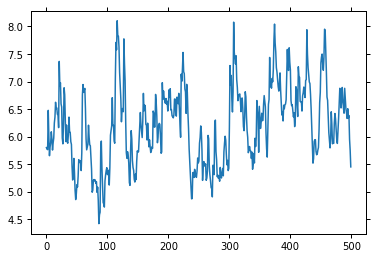

In [43]:
#plotPerformance(dataNewNew)
data=dataNewNew
predictionsByWorkout, targetsByWorkout = transformData(data, scalingFactor=250)
residuals = predictionsByWorkout-targetsByWorkout
#Compute the means and standard deviations of the residuals
means = residuals.mean(0)
stds = residuals.std(0)
indices=np.array(range(len(means)))
#Plot the mean exercise sequence with error bars representing the standard deviation
plt.figure()
plt.errorbar(indices, means, yerr=stds)
#plt.plot([1,2,3],[1,1,1])
plt.show()

In [2]:
#dataWithSport = loadData('logs/fullData/05_36PM_October_29_2016_epoch_39')
#dataWithoutSport = loadData('logs/fullData/10_45PM_October_30_2016_epoch_39')
#newFeedData=loadData('logs/fullData/12_16PM_November_02_2016_epoch_13')

#MAE
newFeedData=loadData('logs/fullData/05_21PM_November_08_2016_epoch_39')
#newFeedData=loadData('logs/fullData/02_45PM_November_11_2016_epoch_28')#Broken large model

#RMSE
#newFeedData=loadData('logs/fullData/03_47PM_November_10_2016_epoch_15')
#newFeedData=loadData('logs/fullData/02_14PM_November_12_2016_epoch_18')


Loading data file
Data file loaded


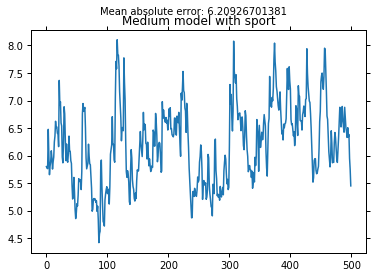

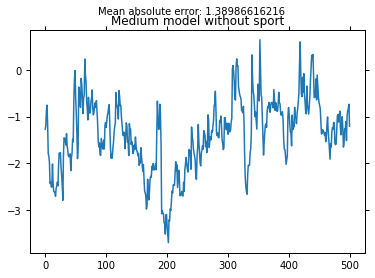

In [79]:
plotPerformance(dataWithSport, plotTitle="Medium model with sport")
plotPerformance(dataWithoutSport, plotTitle="Medium model without sport")

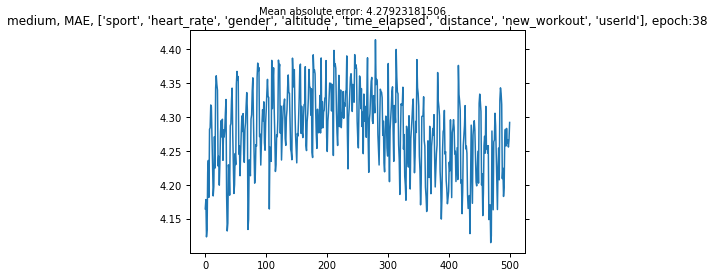

In [21]:
plotPerformance(newFeedData)

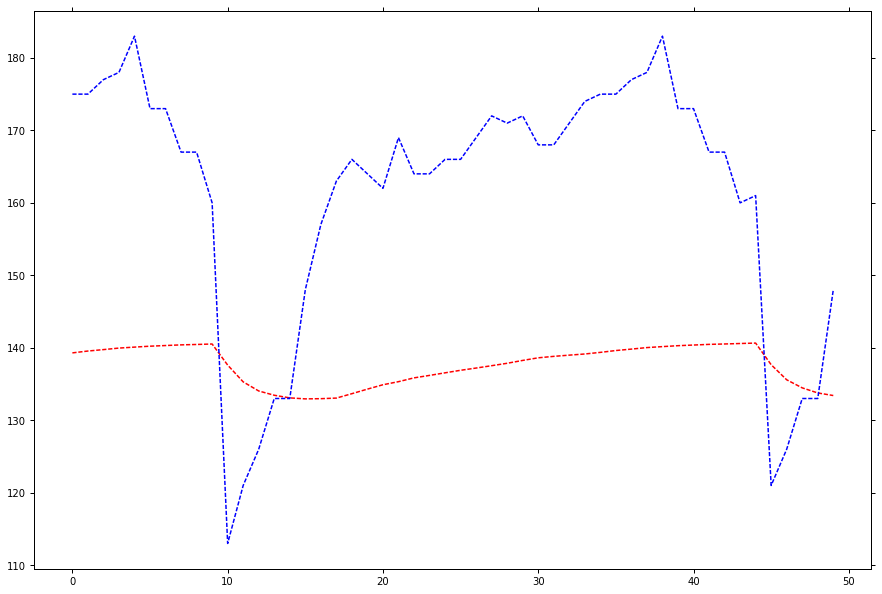

In [ ]:
#plotPerformance(dataNewNew)
data=newFeedData
predictionsByWorkout, targetsByWorkout = transformData(data, sequenceLength=50, scalingFactor=250)
#residuals = predictionsByWorkout-targetsByWorkout
#Compute the means and standard deviations of the residuals

subsetStart=200
subsetEnd=201
predictionsByWorkoutSubset=predictionsByWorkout[subsetStart:subsetEnd,:]
targetsByWorkoutSubset=targetsByWorkout[subsetStart:subsetEnd,:]
meansPred = predictionsByWorkoutSubset.mean(0)
stdsPred = predictionsByWorkoutSubset.std(0)
meansTar = targetsByWorkoutSubset.mean(0)
stdsTar = targetsByWorkoutSubset.std(0)
indices=np.array(range(len(meansTar)))
#Plot the mean exercise sequence with error bars representing the standard deviation
plt.figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')

plt.plot(indices, meansPred, 'r--', indices, meansTar, 'b--')
#plt.title("Average predicted heart rates")
#plt.plot([1,2,3],[1,1,1])
plt.show()

#plt.figure()
#plt.errorbar(indices, meansTar)
#plt.title("Average target heart rates")
#plt.plot([1,2,3],[1,1,1])
#plt.show()



In [6]:
print("Model MAE: " + str(sampleModelPerformance(newFeedData, scalingFactor=250, errorType="MAE")))
print("Benchmark MAE: " + str(sampleAverageBenchmark(newFeedData, scalingFactor=250, errorType="MAE")))
print("Model RMSE: " + str(sampleModelPerformance(newFeedData, scalingFactor=250, errorType="RMSE")))
print("Benchmark RMSE: " + str(sampleAverageBenchmark(newFeedData, scalingFactor=250, errorType="RMSE")))

Model MAE: 18.7523
Benchmark MAE: 19.1336
Model RMSE: 25.0159
Benchmark RMSE: 24.9553


In [8]:
LarryModelData=loadData('logs/fullData/04_17PM_November_17_2016_epoch_55')

Loading data file
Data file loaded


In [9]:
print("Model MAE: " + str(sampleModelPerformance(LarryModelData, scalingFactor=250, errorType="MAE")))
print("Benchmark MAE: " + str(sampleAverageBenchmark(LarryModelData, scalingFactor=250, errorType="MAE")))
print("Model RMSE: " + str(sampleModelPerformance(LarryModelData, scalingFactor=250, errorType="RMSE")))
print("Benchmark RMSE: " + str(sampleAverageBenchmark(LarryModelData, scalingFactor=250, errorType="RMSE")))

Model MAE: 18.9295
Benchmark MAE: 18.3661
Model RMSE: 25.6862
Benchmark RMSE: 24.1778


In [3]:
#LarryModelData=loadData('logs/fullData/01_26PM_November_26_2016_epoch_28')
LarryModelData=loadData('logs/fullData/12_26PM_November_27_2016_epoch_40')

Loading data file
Data file loaded


In [3]:
print("Model MAE: " + str(sampleModelPerformance(LarryModelData, errorType="MAE")))
print("Benchmark MAE: " + str(sampleAverageBenchmark(LarryModelData, errorType="MAE")))
print("Model RMSE: " + str(sampleModelPerformance(LarryModelData, errorType="RMSE")))
print("Benchmark RMSE: " + str(sampleAverageBenchmark(LarryModelData, errorType="RMSE")))

Model MAE: 1.17722
Benchmark MAE: 1.1656
Model RMSE: 1.48577
Benchmark RMSE: 1.48136


In [ ]:
Model MAE: 362.149
Benchmark MAE: 318.537
Model RMSE: 497.701
Benchmark RMSE: 426.248
   
Epoch 21
Model MAE: 317.967
Benchmark MAE: 319.805
Model RMSE: 423.195
Benchmark RMSE: 422.326
    
Epoch 22
Model MAE: 313.596
Benchmark MAE: 310.068
Model RMSE: 425.217
Benchmark RMSE: 424.512
    
Epoch 28
Model MAE: 311.746
Benchmark MAE: 312.322
Model RMSE: 458.138
Benchmark RMSE: 450.739
Model MAE: 1.24698
Benchmark MAE: 1.24929
Model RMSE: 1.83255
Benchmark RMSE: 1.80296

In [2]:
LarryModelData=loadData('logs/fullData/12_26PM_November_27_2016_epoch_47')

Loading data file
Data file loaded


In [ ]:
Epoch 40
Model MAE: 1.19907
Benchmark MAE: 1.2051
Model RMSE: 1.5646
Benchmark RMSE: 1.54443
    


In [21]:
LarryModelData=loadData('logs/fullData/10_12PM_November_30_2016_epoch_7')

Loading data file
Data file loaded


In [22]:
print("Model MAE: " + str(sampleModelPerformance(LarryModelData, errorType="MAE")))
print("Benchmark MAE: " + str(sampleAverageBenchmark(LarryModelData, errorType="MAE")))
print("Model RMSE: " + str(sampleModelPerformance(LarryModelData, errorType="RMSE")))
print("Benchmark RMSE: " + str(sampleAverageBenchmark(LarryModelData, errorType="RMSE")))

Model MAE: 3.4595
Benchmark MAE: 3.15916
Model RMSE: 4.4717
Benchmark RMSE: 4.25654


In [16]:
LarryModelData=loadData('logs/fullData/09_18PM_November_30_2016_epoch_23')

Loading data file
Data file loaded


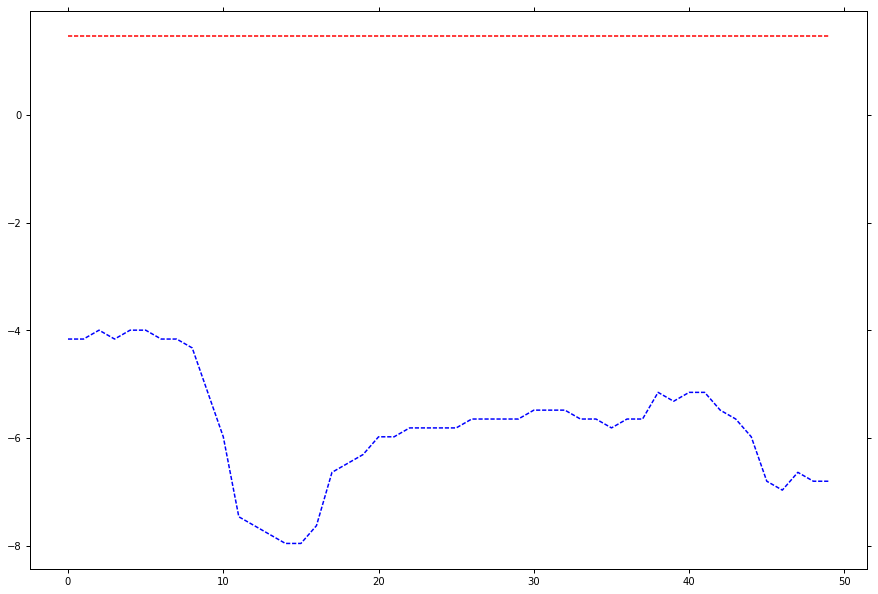

In [36]:
#plotPerformance(dataNewNew)
data=LarryModelData
predictionsByWorkout, targetsByWorkout = transformData(data, sequenceLength=50, scalingFactor=1)
#residuals = predictionsByWorkout-targetsByWorkout
#Compute the means and standard deviations of the residuals


subsetStart=200
subsetLength = 1

subsetEnd=subsetStart + subsetLength
predictionsByWorkoutSubset=predictionsByWorkout[subsetStart:subsetEnd,:]
targetsByWorkoutSubset=targetsByWorkout[subsetStart:subsetEnd,:]
meansPred = predictionsByWorkoutSubset.mean(0)
stdsPred = predictionsByWorkoutSubset.std(0)
meansTar = targetsByWorkoutSubset.mean(0)
stdsTar = targetsByWorkoutSubset.std(0)
indices=np.array(range(len(meansTar)))
#Plot the mean exercise sequence with error bars representing the standard deviation
plt.figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')

plt.plot(indices, meansPred, 'r--', indices, meansTar, 'b--')
#plt.title("Average predicted heart rates")
#plt.plot([1,2,3],[1,1,1])
plt.show()


In [24]:
print("Model MAE: " + str(sampleModelPerformance(LarryModelData, errorType="MAE")))
print("Benchmark MAE: " + str(sampleAverageBenchmark(LarryModelData, errorType="MAE")))
print("Model RMSE: " + str(sampleModelPerformance(LarryModelData, errorType="RMSE")))
print("Benchmark RMSE: " + str(sampleAverageBenchmark(LarryModelData, errorType="RMSE")))

Model MAE: 3.4595
Benchmark MAE: 3.15916
Model RMSE: 4.4717
Benchmark RMSE: 4.25654


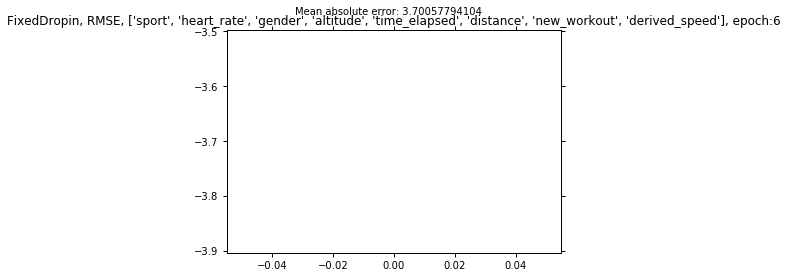

In [33]:
plotPerformance(LarryModelData, scalingFactor=1)

In [26]:
meansPred

array([ 1.46589363,  1.46325123,  1.46526861,  1.46664631,  1.46601284,
        1.46541405,  1.4650569 ,  1.46528339,  1.46563601,  1.46569252,
        1.46555674,  1.46543443,  1.46543276,  1.4654994 ,  1.46553874,
        1.46552765,  1.46550059,  1.46549046,  1.46549916,  1.46550846,
        1.46550989,  1.46550536,  1.46550274,  1.46550369,  1.4655056 ,
        2.43347263,  0.56486416,  1.89052033,  1.40763223,  1.41689944,
        1.51326799,  1.43186188,  1.47367477,  1.47198617,  1.46327114,
        1.46589363,  1.46325123,  1.46526861,  1.46664631,  1.46601284,
        1.46541405,  1.4650569 ,  1.46528339,  1.46563601,  1.46569252,
        1.46555674,  1.46543443,  1.46543276,  1.4654994 ,  1.46553874])

In [30]:
np.min(targetsByWorkout)

-10.762886047363281

In [6]:
#LarryModelData=loadData('logs/fullData/01_30PM_January_18_2017_epoch_40')
#Model MAE: 2.99278
#Benchmark MAE: 3.0484
#Model RMSE: 3.87497
#Benchmark RMSE: 3.9492
#LarryModelData=loadData('logs/fullData/02_04PM_January_18_2017_epoch_16')
#Model MAE: 2.99331
#Benchmark MAE: 3.06638
#Model RMSE: 3.97121
#Benchmark RMSE: 3.97466
#LarryModelData=loadData('logs/fullData/02_04PM_January_18_2017_epoch_40')
#Model MAE: 3.08451
#Benchmark MAE: 3.14874
#Model RMSE: 4.09246
#Benchmark RMSE: 4.13213
#LarryModelData=loadData('logs/fullData/04_57PM_January_22_2017_epoch_45')
#Model MAE: 3.03515
#Benchmark MAE: 3.25839
#Model RMSE: 4.2909
#Benchmark RMSE: 4.44407
#LarryModelData=loadData('logs/fullData/08_26PM_January_22_2017_epoch_45')
#Model MAE: 2.8392
#Benchmark MAE: 2.96167
#Model RMSE: 3.8342
#Benchmark RMSE: 3.98606

#LarryModelData=loadData('logs/fullData/09_13PM_January_30_2017_epoch_56RMSE_noDI_newInpLog')
#LarryModelData=loadData('logs/fullData/01_04AM_January_31_2017_epoch_56RMSE_noDI_noPath_newInpLog')

#LarryModelData=loadData('logs/fullData/05_46PM_February_05_2017_epoch_43_450_RMSE_noDI_speedTarget')
#LarryModelData=loadData('logs/fullData/11_37PM_February_05_2017_epoch_45_450_RMSE_DI_newInpLog')
LarryModelData=loadData('logs/fullData/03_38PM_February_06_2017_epoch_55_450_RMSE_noDI_newInpLog')

Loading data file
Data file loaded


Model MAE: 16.6249
Benchmark MAE: 17.6179
Model RMSE: 21.6886
Benchmark RMSE: 22.7552
MAE diff: -0.993
RMSE diff: -1.06662


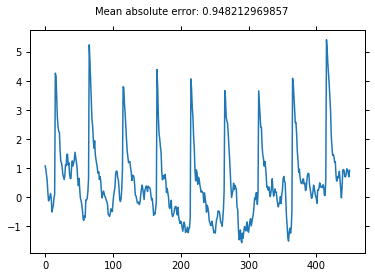

In [7]:
model_mae = sampleModelPerformance(LarryModelData, errorType="MAE")
print("Model MAE: " + str(model_mae))
bench_mae = sampleAverageBenchmark(LarryModelData, errorType="MAE")
print("Benchmark MAE: " + str(bench_mae))
model_rmse = sampleModelPerformance(LarryModelData, errorType="RMSE")
print("Model RMSE: " + str(model_rmse))
bench_rmse = sampleAverageBenchmark(LarryModelData, errorType="RMSE")
print("Benchmark RMSE: " + str(bench_rmse))

print("MAE diff: " + str(model_mae-bench_mae))
print("RMSE diff: " + str(model_rmse-bench_rmse))
plotPerformance(LarryModelData, plotTitle="", sequenceLength = 450)

TypeError: 'dataEpoch' object has no attribute '__getitem__'

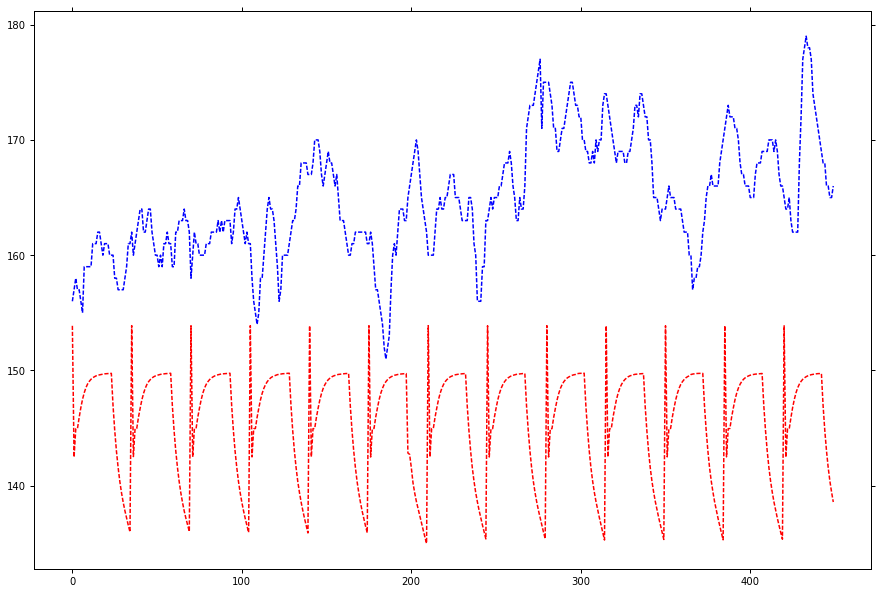

In [8]:
#plotPerformance(dataNewNew)
data=LarryModelData
predictionsByWorkout, targetsByWorkout = transformData(data, sequenceLength=450, unZscore = True)
#residuals = predictionsByWorkout-targetsByWorkout
#Compute the means and standard deviations of the residuals


subsetStart=0
subsetLength = 1

subsetEnd=subsetStart + subsetLength
predictionsByWorkoutSubset=predictionsByWorkout[subsetStart:subsetEnd,:]
targetsByWorkoutSubset=targetsByWorkout[subsetStart:subsetEnd,:]
meansPred = np.mean(predictionsByWorkoutSubset, axis=0)
stdsPred = np.std(predictionsByWorkoutSubset)
meansTar = np.mean(targetsByWorkoutSubset, axis=0)
stdsTar = np.std(targetsByWorkoutSubset, axis=0)
indices=np.array(range(len(meansTar)))
#Plot the mean exercise sequence with error bars representing the standard deviation
plt.figure(num=None, figsize=(15, 10), dpi=100, facecolor='w', edgecolor='k')

plt.plot(indices, meansPred, 'r--', indices, meansTar, 'b--')
plt.title(data[subsetStart,0]["url"])
plt.show

In [78]:
inputOrderSeq = [x for x in LarryModelData.endoFeatures if x!= LarryModelData.targetAtt]
print(inputOrderSeq)
LarryModelData.inputSeq[0]

['new_workout', 'gender', 'sport', 'userId', 'altitude', 'distance', 'derived_speed', 'time_elapsed']


[-0.22385728,
 'male',
 'run',
 3575734,
 -0.0039260429,
 -0.0072798198,
 -0.011107814,
 -0.034275606]

In [118]:
predictionsByWorkout, targetsByWorkout, inputAttsByWorkout = transformData(LarryModelData, sequenceLength=500, unZscore = True, useInputs=True)

Loading metadata
Metadata loaded


In [79]:
len(inputAttsByWorkout["derived_speed"][0])

500

In [86]:
df = buildDataFrame(LarryModelData)

Loading metadata
Metadata loaded


ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [244]:
reload(Sequence_Frame)
#from Sequence_Frame import Sequence_Frame
import Sequence_Frame
predictionsByWorkout, targetsByWorkout, inputAttsByWorkout = transformData(LarryModelData, sequenceLength=500, unZscore = True, useInputs=True)
sf = Sequence_Frame.Sequence_Frame(predictionsByWorkout, targetsByWorkout, inputAttsByWorkout, LarryModelData)


Num rows: 361


In [245]:
print(sf.attributes)
row_slice = sf.slice_rows_by_att_vals(["sport"], ["run"], colvars = ['targets'])
#len(sf.values[1])
print(len(row_slice))
#row_slice[0][4]
np.mean(row_slice)

['predictions', 'targets', 'new_workout', 'gender', 'sport', 'userId', 'altitude', 'distance', 'derived_speed', 'time_elapsed']
144


147.6721249962383

In [158]:
inputAttsByWorkout["sport"][2][0]

'hiking'

In [249]:
row_slice = sf.slice_rows_by_att_vals(["sport"], ["run"], colvars = ['predictions', 'targets'])
print("run prediciton mean hr: " + str(np.mean(row_slice[:][0])))#mean prediction
print("run target mean hr: " + str(np.mean(row_slice[:][1])))#mean target

row_slice = sf.slice_rows_by_att_vals(["sport"], ["bike"], colvars = ['predictions', 'targets'])
print("bike prediciton mean hr: " + str(np.mean(row_slice[:][0])))#mean prediction
print("bike target mean hr: " + str(np.mean(row_slice[:][1])))#mean target

run prediciton mean hr: 149.746052948
run target mean hr: 132.431533737
bike prediciton mean hr: 134.795075668
bike target mean hr: 117.393530167
